In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import pandas as pd
from datetime import datetime as dt
import tensorflow as tf
import seaborn as sns

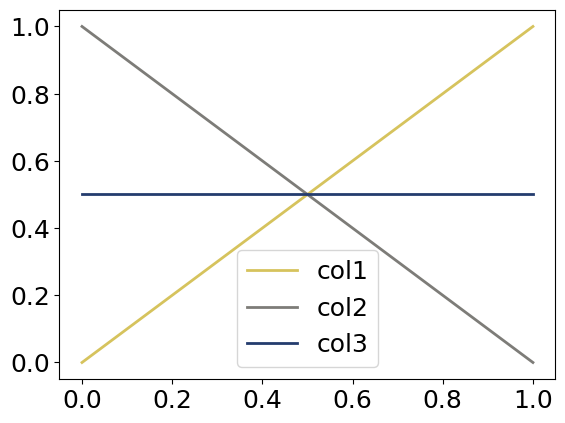

In [2]:
#plot settings
font = {'family': 'sans-serif', 'size': 18}
plt.rc('font', **font)
lw = 2. #linewidth for all plots

col_map = cm.cividis
norm = Normalize(vmin=-10, vmax=10)
col1 = col_map(norm(7))
col2 = col_map(norm(0))
col3 = col_map(norm(-7))

plt.figure()
plt.plot([0, 1], [0, 1], color=col1, label='col1', linewidth = lw)
plt.plot([0, 1], [1, 0], color=col2, label='col2', linewidth = lw)
plt.plot([0, 1], [.5, .5], color=col3, label='col3', linewidth = lw)
plt.legend();

In [3]:
df_pres = pd.read_csv('df_pres.csv')
print(df_pres.iloc[11*len(df_pres)//16])

def get_days(m1, y1, m2, y2):
    ndays = (y2-y1)*360 + (m2-m1)*30
    return ndays

year                  2005
month                    2
inflation              3.0
interest               2.5
unemployment           5.4
CPI                  191.8
senate_pol         0.68584
house_pol         0.810044
approval              49.0
disapproval           48.0
president       G. W. Bush
Name: 1609, dtype: object


## first, let's visualize approval ratings of a few two-term presidents

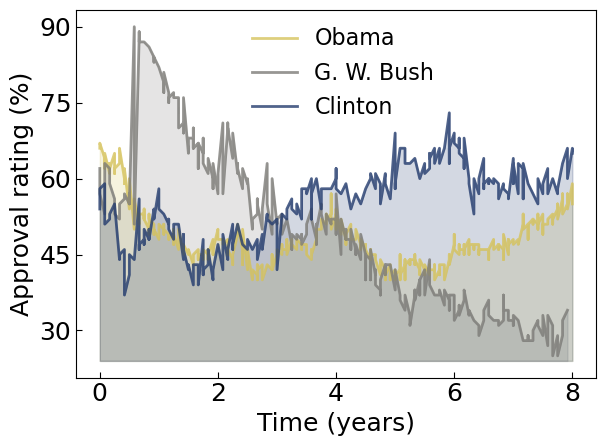

In [4]:
col_list = [col1, col2, col3]

fig, ax = plt.subplots()

for i, pres in enumerate(['Obama', 'G. W. Bush', 'Clinton']):

    df = df_pres[df_pres['president']==pres]
    
    #first, let's fix the x-axis, which should be time: change from date -> # of days in office
    start_year = min(df['year'])
    start_month = min(df[df['year']==start_year].month)
    end_year = max(df['year'])
    end_month = max(df[df['year']==end_year].month)
    
    X = get_days(start_month, start_year, df.month.to_numpy(), df.year.to_numpy())/360
            
    Y1 = df.approval.astype(float).to_numpy()
    
    ax.plot(X, Y1, color = col_list[i], linewidth = lw, alpha = .8, label = pres)
    ax.fill_between(X, Y1, 24, color = col_list[i], alpha = .2)
    ax.set_ylabel('Approval rating (%)')
    ax.set_xlabel('Time (years)')
    
    ax.tick_params(axis="y", direction="in", length = 4)
    ax.tick_params(axis="x", direction="in", length = 4)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))

    ax.legend(fontsize = 16, frameon = False, bbox_to_anchor=(0.3,0.65))
    
    plt.tight_layout()

One of the biggest flaws of any model we could construct is that it wouldn't take into account major events that can have an impact on approval ratings, a bit like black swan events affecting the stock markets. For instance, 9/11 and Bush's rise in approval rating as a result of the country standing behind their leader following a major terrorist attack won't ever be predicted by any model...and by its nature, it shouldn't.

## time series visualization

['inflation', 'interest', 'unemployment', 'CPI', 'senate_pol', 'house_pol', 'approval', 'disapproval']
[1914, 1959, 1991, 2009, 2024]


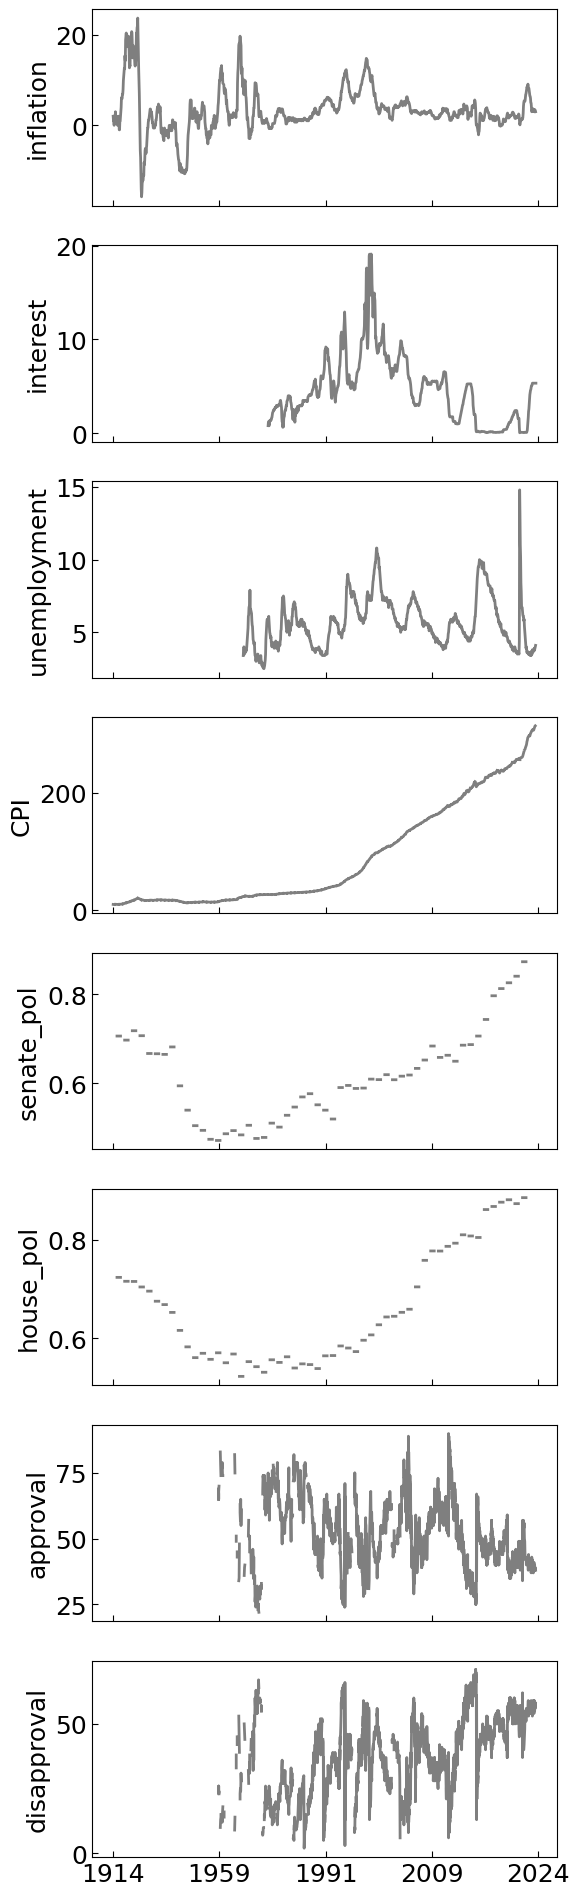

In [84]:
fig, axs = plt.subplots(8, 1, figsize = (6, 24), sharex=True)

year0 = min(df_pres.year)
month0 = min(df_pres.month)
ndays = get_days(month0, year0, df_pres.month, df_pres.year).to_numpy()

cols = df_pres.columns
l = [i for i in all_cols][2:-1]
print(l)

for i, ax in enumerate(axs):

    col = str(l[i])

    ax.plot(ndays, df_pres[col], color = 'k', alpha = .5, linewidth = 2)
    ax.set_ylabel(col)
    ax.tick_params(axis="y", direction="in", length=4)
    ax.tick_params(axis="x", direction="in", length=4)

    ax.set_xticks(np.linspace(0, 40000, 5))

year_ticks = [df_pres['year'].iloc[int(j)] for j in np.linspace(0, len(df_pres)-1, 5)]
print(year_ticks)
ax.set_xticklabels(year_ticks);

## visualize correlation 

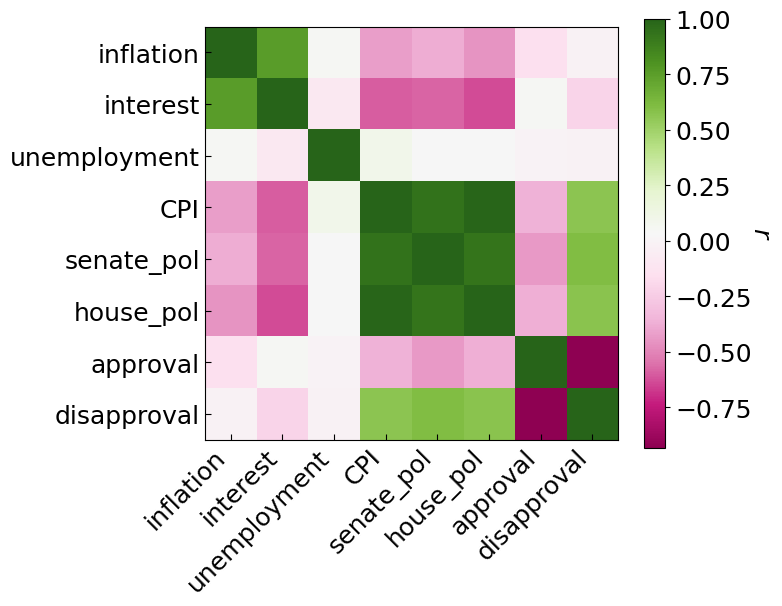

In [48]:
#drop nas and remove features we don't care to visualize
num_df_pres = df_pres.select_dtypes(include=['float64', 'float32', 'int64', 'int32'])
num_df_pres = num_df_pres.drop(['year', 'month'], axis = 1)
num_df_pres = num_df_pres.dropna()


tensor = tf.convert_to_tensor(num_df_pres.values, dtype=tf.float32) #first, convert to tensor
mean = tf.reduce_mean(tensor, axis=0)
tensor_centered = tensor - mean
cov = tf.matmul(tensor_centered, tensor_centered, transpose_a=True) / tf.cast(tf.shape(tensor)[0] - 1, tf.float32)
stddev = tf.sqrt(tf.linalg.diag_part(cov))
corr = cov/tf.tensordot(stddev, stddev, axes=0).numpy()


fig, ax = plt.subplots(figsize=(8, 8))
p = ax.imshow(corr, cmap='PiYG')
all_cols = num_df_pres.columns
l = [i for i in all_cols]

ax.set_xticks(range(len(l)))
ax.set_yticks(range(len(l)))
ax.set_xticklabels(l, rotation=45, ha="right")
ax.set_yticklabels(l, rotation=0)
cbar = plt.colorbar(p, shrink = .66)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$r$', rotation=270)

ax.tick_params(axis="y", direction="in", length=4)
ax.tick_params(axis="x", direction="in", length=4)

plt.tight_layout()
plt.show()

based on the above correlation matrix, it appears that unemployment has very weak correlations with any of the other predictors, including the target itself. It's unlikely to be a strong predictor for approval ratings. Most of the labels are at best weak correlators...save for senate_polarization, and to a lesser degree house polarization followed by CPI and inflation. 
Big, big disclaimer. Analyzing correlations is a simplistic way to looking at the data. I am in no way making any claim about causation. A and B can be correlated and both caused by C, but not by each other, and that's fine. 